# Error Plots for JCPexample 2

## Unsteady Stokes Flow in Rotating Disk

### Import Stuff

In [1]:
import torch
import torch.nn as nn
import os
import sys

sys.path.append('../')

import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat
import pickle
import importlib
import DRLPDE.neuralnets as neuralnets

import matplotlib.pyplot as plt
import cv2

import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.size'] = 12

### Load Model and Setup Variables

In [3]:
loadmodel = 'JCPexample2'

filename = 'Error_Plot_' + loadmodel
imagesfolder = "images/"

with open('../experiments/' + loadmodel + '_parameters.pickle', 'rb') as f:
    parameters = pickle.load(f)

with open('../experiments/'  + loadmodel + '_losses.pickle', 'rb') as f:
    losses = pickle.load(f)

with open('../experiments/'  + loadmodel + '_errors.pickle', 'rb') as f:
    errors = pickle.load(f)

problem = importlib.import_module(".JCPexample2", package='examples')

input_dim = [problem.x_dim, problem.t_dim, problem.hyper_dim]
output_dim = problem.output_dim

if parameters['neuralnetwork'] == 'FeedForward':
    MyNeuralNetwork = neuralnets.FeedForwardNN
elif parameters['neuralnetwork'] == 'Incompressible':
    MyNeuralNetwork = neuralnets.IncompressibleNN

nn_size = parameters['nn_size']

model = MyNeuralNetwork(input_dim, output_dim, **nn_size)
model.load_state_dict(torch.load("../savedmodels/" + loadmodel + ".pt"))

dim_space = 2
dim_full = dim_space + 1

mu = 1.0
L = 1.0  # Length of box the circle/sphere sits inside + Radius of Disk/Sphere
v0 = 1.0
maxT = 1.0 # Max time

numpts_r = 20
numpts_th =  120
numpts_time = 100
dtime = maxT/numpts_time

r,th,t_var = torch.meshgrid([torch.linspace(0,1, numpts_r), \
                         torch.linspace(0,2*math.pi, numpts_th), \
                         torch.linspace(0,maxT, numpts_time+1)])

x1g = r*torch.cos(th)
x2g = r*torch.sin(th)

xg = torch.stack([x1g.reshape(-1), x2g.reshape(-1), t_var.reshape(-1)], dim=-1)

#### Analytic Solution

u1_true = - v0*r*torch.sin(th)
u2_true = v0*r*torch.cos(th)

Truncate = 20

roots = bessel.jn_zeros(1,Truncate)

c = np.zeros(Truncate)

for jj in range(0,Truncate):
    c[jj] = 2*(-bessel.j0(roots[jj])/roots[jj])/(bessel.jv(2,roots[jj])**2) # Much more accurate for later terms

    u1_true += v0*c[jj]*torch.sin(th)*torch.tensor(bessel.j1(roots[jj]*r.numpy()))*torch.exp(-mu*roots[jj]**2*t_var)
    u2_true += -v0*c[jj]*torch.cos(th)*torch.tensor(bessel.j1(roots[jj]*r.numpy()))*torch.exp(-mu*roots[jj]**2*t_var)

u1_true[0:-1, :, 0] = 0
u2_true[0:-1, :, 0] = 0
u_true = torch.stack([u1_true, u2_true], dim=-1)

####################################################################

u1_true = u1_true.numpy()
u2_true = u2_true.numpy()

L2_error_U = 0 
L2_error_V = 0

Linf_error_U = 0
Linf_error_V = 0

L2_norm_true_U = 0
L2_norm_true_V = 0

Linf_norm_true = np.max(np.abs(u_true.numpy()))

############# Plot, Video, Error ##################################

r_plot, th_plot = torch.meshgrid([torch.linspace(0,1, numpts_r),
                                 torch.linspace(0,2*math.pi, numpts_th)])

x1plot = r_plot*torch.cos(th_plot)
x2plot = r_plot*torch.sin(th_plot)

xplot = torch.stack( [x1plot.reshape(-1), x2plot.reshape(-1), torch.zeros((numpts_r*numpts_th))], dim=-1).requires_grad_(True)

integral_factor = 2*math.pi*maxT*r_plot/(numpts_r-1)/(numpts_th-1)/(numpts_time-1)
integral_factor = integral_factor.numpy()

x1plot = x1plot.numpy()
x2plot = x2plot.numpy()

for ii in range(0,numpts_time):
    index = '0' + str(ii)
    
    xplot.requires_grad_(False)
    xplot[:,2] = dtime*ii

    Trained_Vel = model(xplot.requires_grad_()).reshape([numpts_r, numpts_th,2]).detach().numpy()

    Trained_Vel_U = Trained_Vel[:,:,0]
    Trained_Vel_V = Trained_Vel[:,:,1]    


    ### All the different Errors and norms ###

    L2_error_U +=  np.sum( ((Trained_Vel_U - u1_true[:,:,ii])**2 )*integral_factor)
    L2_error_V +=  np.sum( ((Trained_Vel_V - u2_true[:,:,ii])**2 )*integral_factor)

    Linf_error_U = np.max([np.max(np.abs(Trained_Vel_U - u1_true[:,:,ii])), Linf_error_U])
    Linf_error_V = np.max([np.max(np.abs(Trained_Vel_V - u2_true[:,:,ii])), Linf_error_V])

    L2_norm_true_U += np.sum( (u1_true[:,:,ii]**2)*integral_factor )
    L2_norm_true_V += np.sum( (u2_true[:,:,ii]**2)*integral_factor )
    

L2_error = np.sqrt(L2_error_U + L2_error_V)
Linf_error = np.max( [Linf_error_U, Linf_error_V])
L2_norm_true = np.sqrt( L2_norm_true_U + L2_norm_true_V )

print('L2_error = {:.4f}'.format(L2_error))

print('Linf_error = {:.4f}'.format(Linf_error))

print('Relative L2_error = {:.4f}'.format(L2_error/L2_norm_true))

print('Relative Linf_error = {:.4f}'.format(Linf_error/Linf_norm_true))

L2_error = 0.1149
Linf_error = 0.9240
Relative L2_error = 0.1956
Relative Linf_error = 0.9240


### Plotting

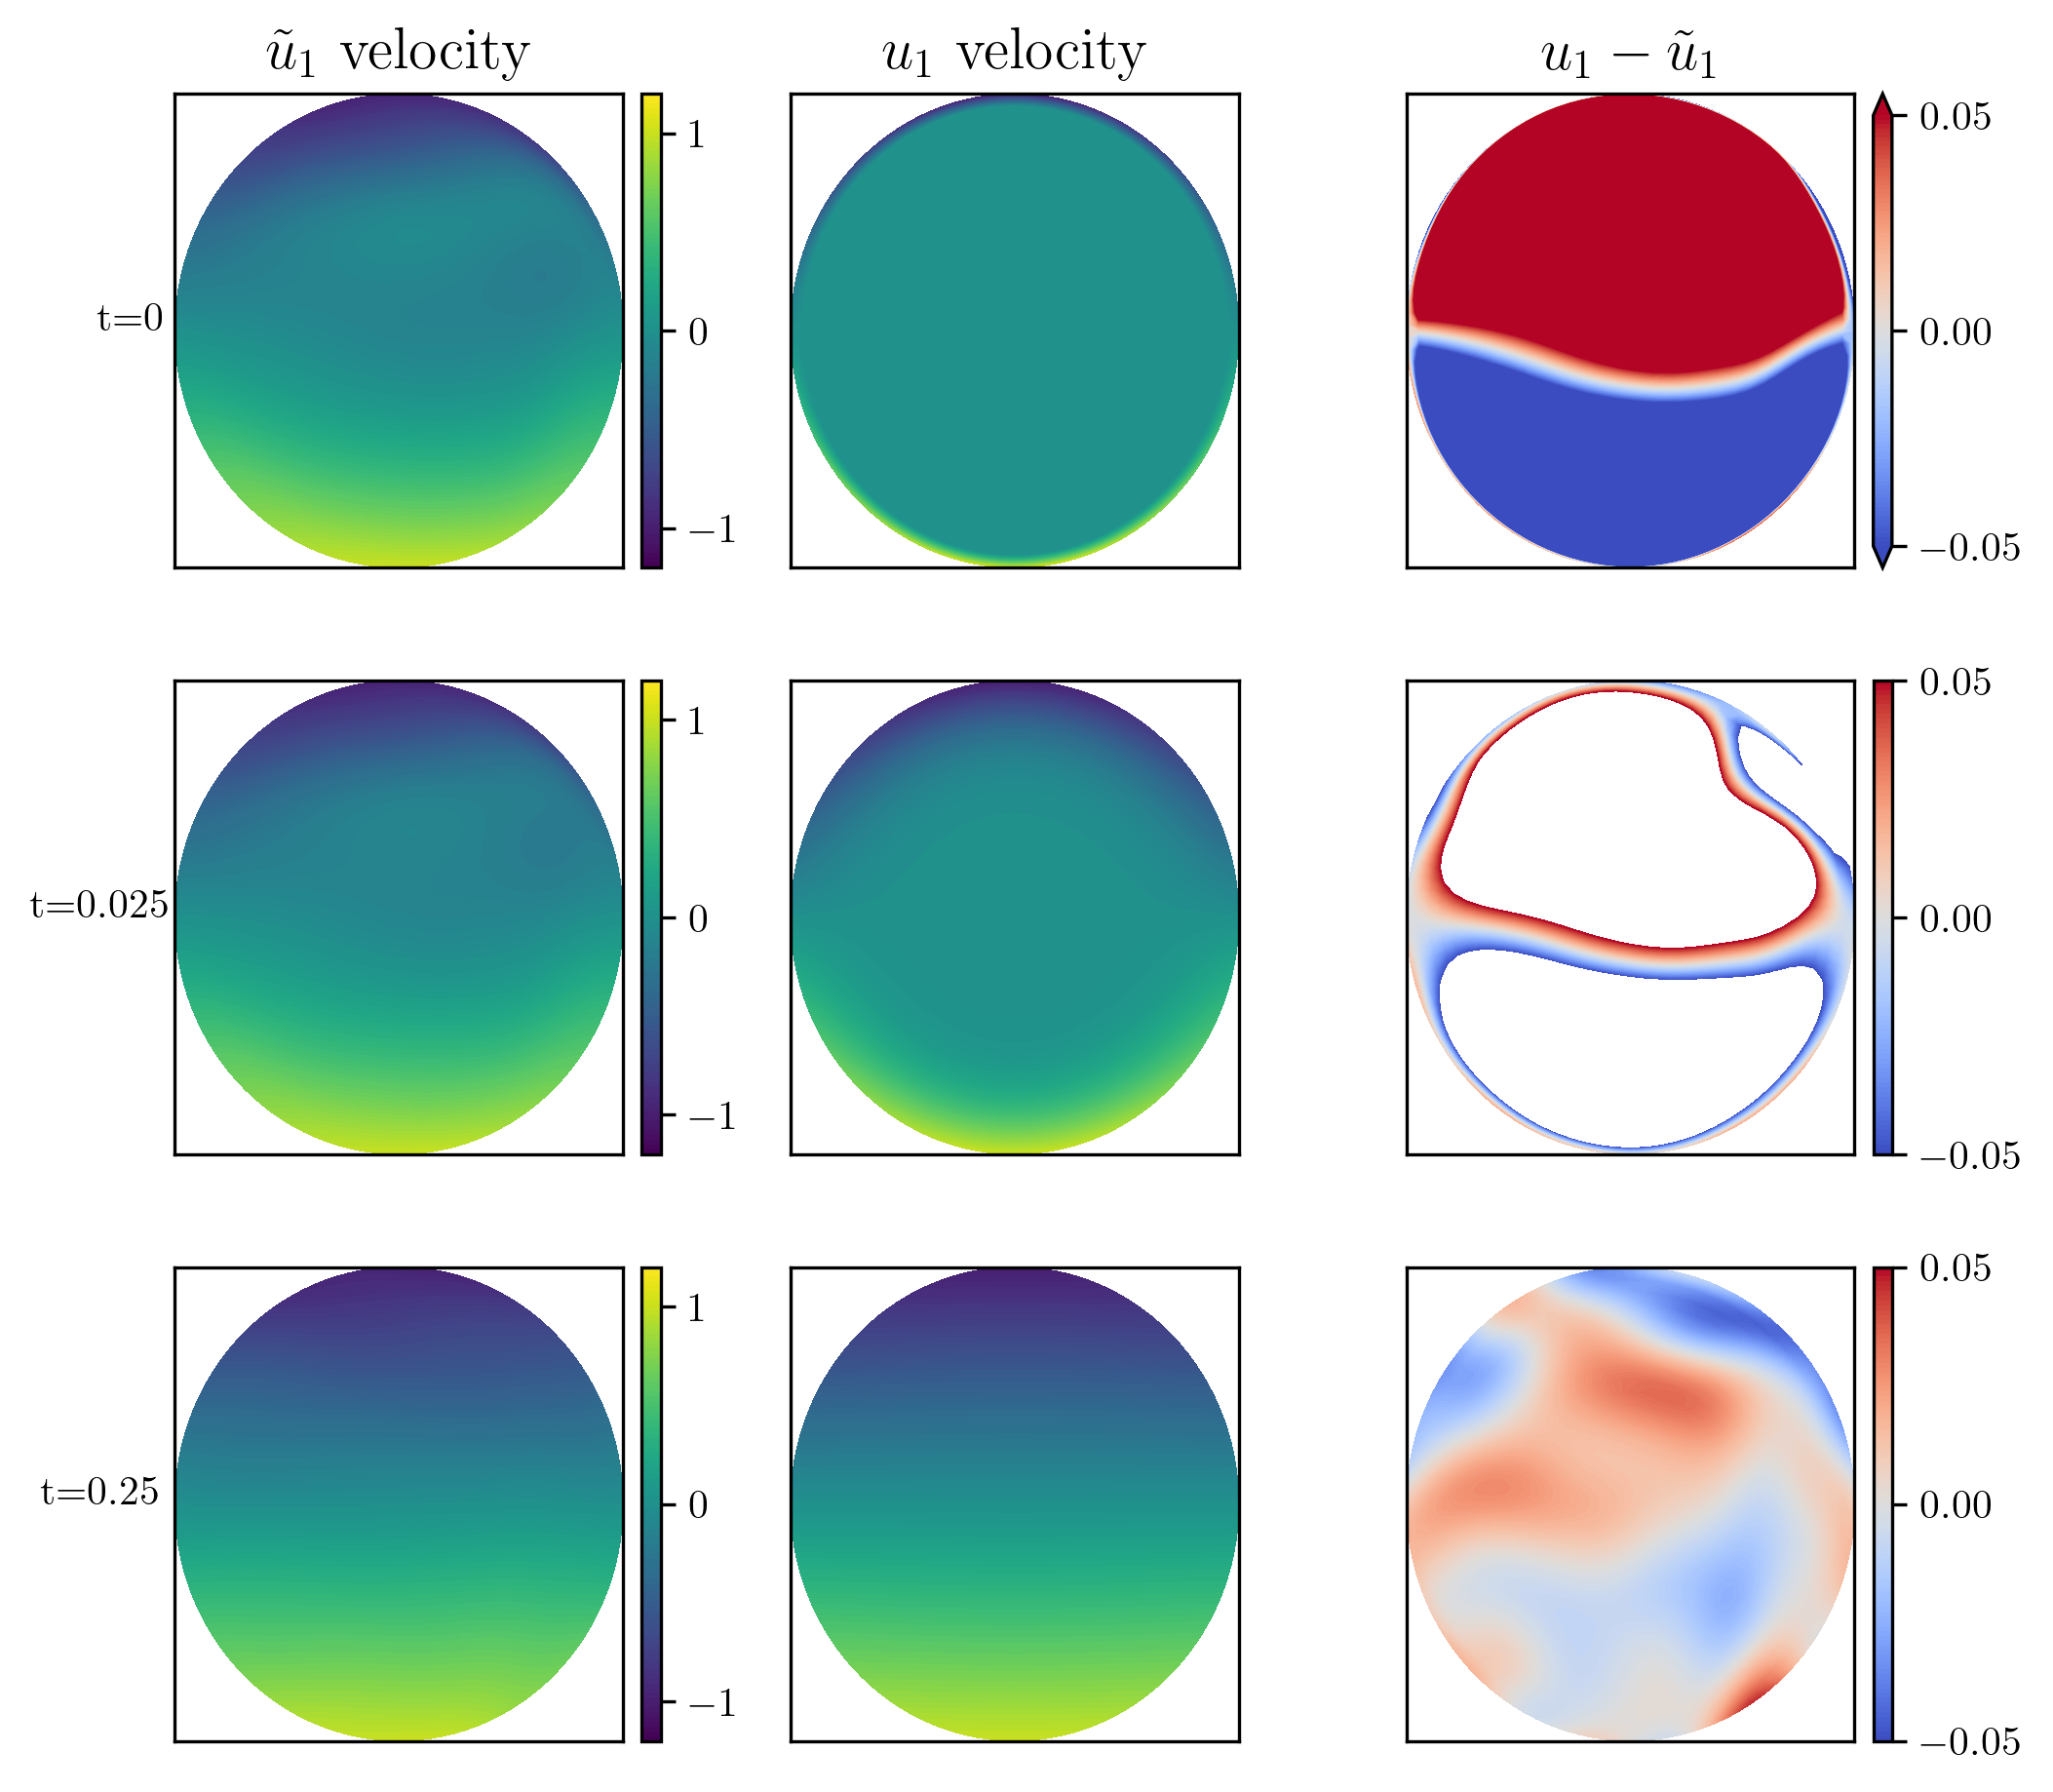

In [4]:
xplot.requires_grad = False
xplot[:,2] = 0
xplot.requires_grad = True

Trained_Vel = model(xplot).reshape([numpts_r, numpts_th, 2]).detach().numpy()

Trained_Vel_U_t0 = Trained_Vel[:,:,0]
u1_true_t0 = u1_true[:,:,0]

xplot.requires_grad = False
xplot[:,2] = dtime*9
xplot.requires_grad = True

Trained_Vel = model(xplot).reshape([numpts_r, numpts_th, 2]).detach().numpy()

Trained_Vel_U_t1 = Trained_Vel[:,:,0]
u1_true_t1 = u1_true[:,:,9]   

xplot.requires_grad = False
xplot[:,2] = dtime*99
xplot.requires_grad = True

Trained_Vel = model(xplot).reshape([numpts_r, numpts_th, 2]).detach().numpy()

Trained_Vel_U_t2 = Trained_Vel[:,:,0]
u1_true_t2 = u1_true[:,:,99] 

#############################################################################

levels_stokes = np.linspace(-1.2, 1.2, 100)
error_levels = np.linspace(-0.05, 0.05, 100)

levels_tick = np.linspace(-1.0, 1.0, 3)
error_tick = np.linspace(-0.05, 0.05, 3)

plt.close('all')
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[6.4,6.1])
plt.tight_layout(pad=0.5)

## Plot 0

contour0 = ax[0,0].contourf(x1plot, x2plot, Trained_Vel_U_t0, 
                            levels=levels_stokes, cmap=plt.cm.viridis)
                            
ax[0,0].set_title(r'$\tilde{u}_1$ velocity')

ax[0,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

ax[0,0].text(-1.35, 0, r't=0', fontsize=10)

colorbar0_param = fig.add_axes(
    [ax[0,0].get_position().x1 + 0.01,
     ax[0,0].get_position().y0,
     0.01,
     ax[0,0].get_position().height])
colorbar0 = plt.colorbar(contour0, ticks=levels_tick, cax = colorbar0_param)
colorbar0.ax.tick_params(labelsize=10)

## Plot 1

contour1 = ax[0,1].contourf(x1plot, x2plot, u1_true_t0, 
                            levels=levels_stokes, cmap=plt.cm.viridis)
ax[0,1].set_title(r'$u_1$ velocity')

ax[0,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

## Plot 2

contour2 = ax[0,2].contourf(x1plot, x2plot, u1_true_t0 - Trained_Vel_U_t0, 
                            levels = error_levels, cmap=plt.cm.coolwarm, extend='both')
ax[0,2].set_title(r'$u_1 - \tilde{u}_1$')

ax[0,2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar2_param = fig.add_axes(
    [ax[0,2].get_position().x1 + 0.01,
     ax[0,2].get_position().y0,
     0.01,
     ax[0,2].get_position().height])
colorbar2 = plt.colorbar(contour2, ticks=error_tick, cax = colorbar2_param)
colorbar2.ax.tick_params(labelsize=10)

## Plot 3

contour3 = ax[1,0].contourf(x1plot, x2plot, Trained_Vel_U_t1, 
                            levels=levels_stokes, cmap=plt.cm.viridis)
ax[1,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

ax[1,0].text(-1.65, 0, r't=0.025', fontsize=10)

colorbar3_param = fig.add_axes(
    [ax[1,0].get_position().x1 + 0.01,
     ax[1,0].get_position().y0,
     0.01,
     ax[1,0].get_position().height])
colorbar3 = plt.colorbar(contour3, ticks=levels_tick, cax = colorbar3_param)
colorbar3.ax.tick_params(labelsize=10)

## Plot 4

contour4 = ax[1,1].contourf(x1plot, x2plot, u1_true_t1, 
                            levels=levels_stokes, cmap=plt.cm.viridis)
ax[1,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

## Plot 5

contour5 = ax[1,2].contourf(x1plot, x2plot, u1_true_t1 - Trained_Vel_U_t1, 
                            error_levels, cmap=plt.cm.coolwarm)
ax[1,2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar5_param = fig.add_axes(
    [ax[1,2].get_position().x1 + 0.01,
     ax[1,2].get_position().y0,
     0.01,
     ax[1,2].get_position().height])
colorbar5 = plt.colorbar(contour5, ticks=error_tick, cax = colorbar5_param)
colorbar5.ax.tick_params(labelsize=10)

## Plot 6

contour6 = ax[2,0].contourf(x1plot, x2plot, Trained_Vel_U_t2, 
                            levels=levels_stokes, cmap=plt.cm.viridis)
ax[2,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

ax[2,0].text(-1.60, 0, r't=0.25', fontsize=10)

colorbar6_param = fig.add_axes(
    [ax[2,0].get_position().x1 + 0.01,
     ax[2,0].get_position().y0,
     0.01,
     ax[2,0].get_position().height])
colorbar6 = plt.colorbar(contour6, ticks=levels_tick, cax = colorbar6_param)
colorbar6.ax.tick_params(labelsize=10)

contour7 = ax[2,1].contourf(x1plot, x2plot, u1_true_t2, 
                            levels=levels_stokes, cmap=plt.cm.viridis)
ax[2,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

contour8 = ax[2,2].contourf(x1plot, x2plot, u1_true_t2 - Trained_Vel_U_t2, 
                            error_levels, cmap=plt.cm.coolwarm)
ax[2,2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar8_param = fig.add_axes(
    [ax[2,2].get_position().x1 + 0.01,
     ax[2,2].get_position().y0,
     0.01,
     ax[2,2].get_position().height])
colorbar8 = plt.colorbar(contour8, ticks=error_tick, cax = colorbar8_param)
colorbar8.ax.tick_params(labelsize=10)


In [8]:
steps = range(int(parameters['trainingsteps']))
L2loss = losses[:,:,0]
Linfloss = np.sqrt(losses[:,:,1])
L2error = np.sqrt(errors[:,:,0])
Linferror = np.sqrt(np.amax(errors[:,:,1], axis=1))

print('Final Interior L2 error = {:.4f}'.format(L2error[-1,0]))
print('Final Boundary L2 error = {:.4f}'.format(L2error[-1,1]))
print('Final Initial Condition L2 error = {:.4f}'.format(L2error[-1,2]))
print('Final Linf error = {:.4f}'.format(Linferror[-1]))

Final Interior L2 error = 0.0076
Final Boundary L2 error = 0.0588
Final Initial Condition L2 error = 1.0114
Final Linf error = 0.9804


Text(0.5, 59.88843513257575, 'number of steps')

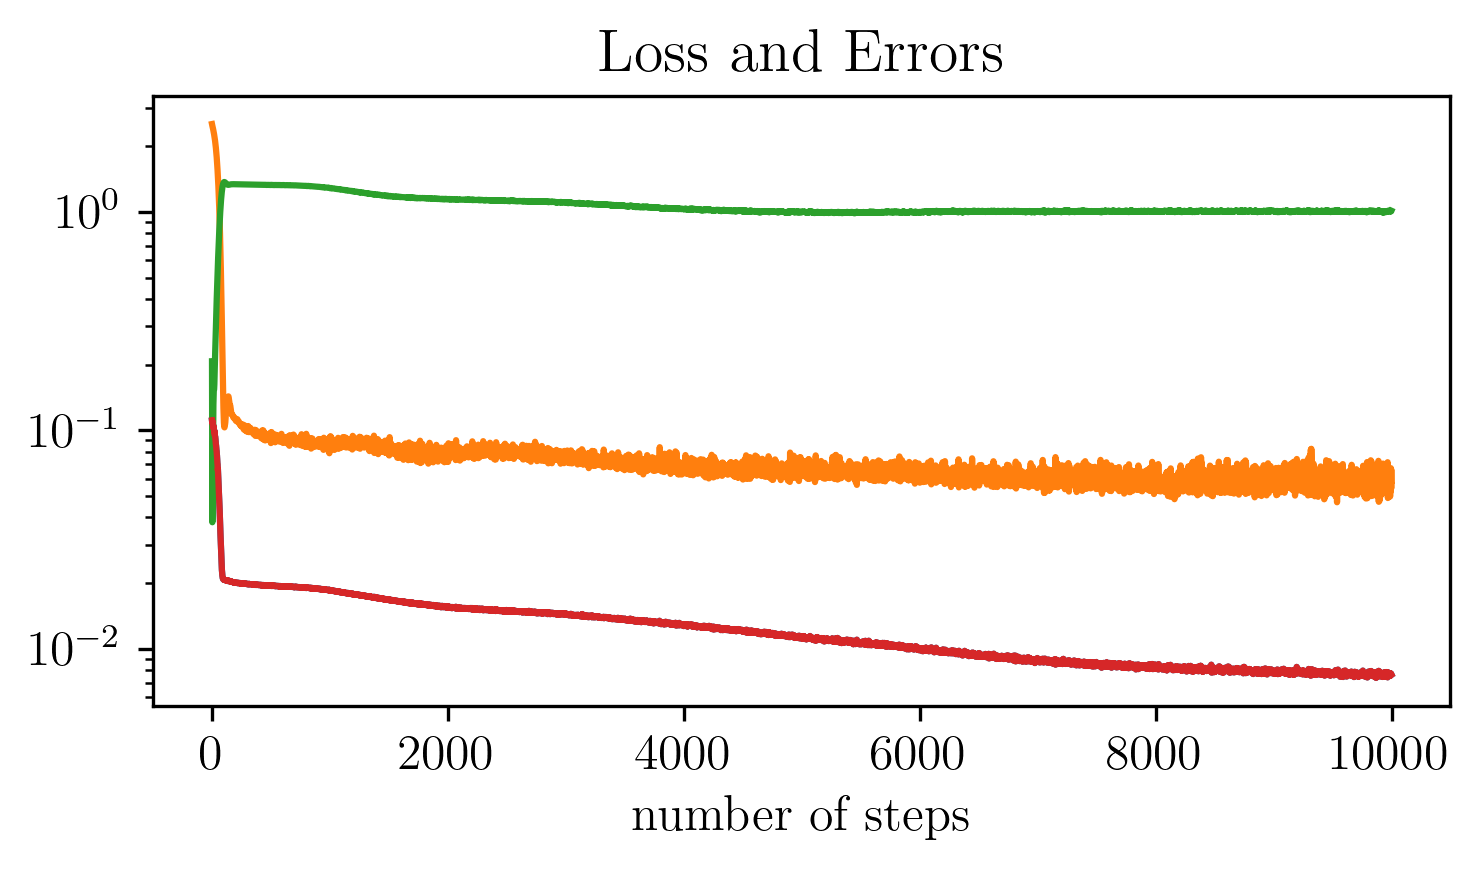

In [10]:
steps = range(int(parameters['trainingsteps']))
L2loss = losses[:,:,0]
Linfloss = np.sqrt(losses[:,:,1])
L2error = np.sqrt(errors[:,:,0])
Linferror = np.sqrt(np.amax(errors[:,:,1], axis=1))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6.4, 4])

plt.tight_layout(pad=5.0)

ax.set_title('Loss and Errors')

ax.semilogy(steps, np.sqrt(L2loss[:,0]))
ax.semilogy(steps, np.sqrt(L2loss[:,1]))
ax.semilogy(steps, np.sqrt(L2loss[:,2]))
#ax.semilogy(steps, np.sqrt(Linfloss[:,0]))
ax.semilogy(steps, L2error[:,0])
#ax.semilogy(steps, Linferror)
#ax.legend(['Interior L2 loss', 'Interior Linf loss', 'Interior L2 error', 'Interior Linf error'])
ax.set_xlabel('number of steps')

#ax[1].set_title('Comparing L2 loss and L2 error')
#ax[1].semilogy(steps, np.abs( 5.1148*L2loss - L2error) )